In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cls_filepath ="drive/MyDrive/NLU Coursework/classes" #Path to the directory containing the classes folder

model_filepath = "drive/MyDrive/NLU Coursework/solution_C/models_C/solution_C.pt" #Path to the model to be demoed
dataset_path = "drive/MyDrive/NLU Coursework/data/training_data/training_data/NLI/dev.csv" #Path to the dataset used for evaluation
labels_path = "drive/MyDrive/NLU Coursework/submissions/Group_17_C.csv" #Path to output the predicted labels

# Evaluation Setup

In [3]:
sys.path.append(cls_filepath) #Path to import the helper methods & classes from. Classes directory must be within this folder
from evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from preprocessing import load_data_csv

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from keras.utils import to_categorical

In [5]:
import json
from random import randint
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import typing
import numpy as np
import pandas as pd

## Functions

In [6]:
def tokenize_data(tokenizer: RobertaTokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses together. Will padd/truncate the sequences of tokens correctly. Formats the sequences together of the format below

      sample = [CLS] Premise [SEP] Hypothesis [SEP]
  """
  return tokenizer(premises, hypotheses, max_length=maxlen, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)

## Variables

In [7]:
INPUTS_IDS_KEY: str = "input_ids"
ATTENTION_MASK_KEY: str = "attention_mask"
TOKEN_TYPE_KEY: str = "token_type_ids"

In [8]:
NUM_LABELS = 2

# Data Preprocessing

## Load Data

In [9]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)

In [10]:
premises_og = premises
hypotheses_og = hypotheses

In [11]:
true = [int(x) for x in true]
labels = torch.tensor(true)

### Example

In [12]:
index = randint(0, len(premises))
print(f"Premise: {premises[index]}")
print(f"Hypothesis: {hypotheses[index]}")
print(f"Label: {labels[index]}")

Premise: The Vatican was upset when the fascist youth movement dissolved the Catholic Boy Scouts.
Hypothesis: The Catholic Boy Scouts were a fascist organization.
Label: 0


## Tokenize Data

In [13]:
BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
demo_data = tokenize_data(tokenizer=tokenizer, premises=list(premises), hypotheses=list(hypotheses), maxlen=512)

In [15]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [16]:
print(f"Sentence: {tokenizer.convert_ids_to_tokens(demo_data[INPUTS_IDS_KEY][0])}")
print(f"Tokens: {demo_data[INPUTS_IDS_KEY]}")

Sentence: ['<s>', 'Mon', 'ĠDie', 'u', '!', 'Ġ', '</s>', '</s>', 'This', 'Ġperson', 'Ġis', 'Ġspeaking', 'ĠEnglish', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

## Format Dataset & Dataloader

In [17]:
dataset = TensorDataset(demo_data[INPUTS_IDS_KEY], demo_data[ATTENTION_MASK_KEY], labels) #note here that the dev dataset is used for testing (evaluation) later
dataloader = DataLoader(dataset, batch_size = 16)


# Load Model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
model = RobertaForSequenceClassification.from_pretrained(BERT_ID, num_labels=NUM_LABELS)

model = model.to(device)
model

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
model.load_state_dict(torch.load(model_filepath))

<All keys matched successfully>

# Make Predictions


In [21]:
#Get the predictions for all of the test cases
predicted_logits = []

for batch in dataloader:
  input_ids, attention_mask, labels = [part.to(device) for part in batch]

  with torch.no_grad():
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels=labels)

  predicted_logits.extend(outputs.logits.detach().cpu())
predicted_logits = np.array(predicted_logits)

In [38]:
predicted_labels = np.argmax(predicted_logits, axis=1)
predicted_logits = torch.nn.functional.softmax(torch.Tensor(predicted_logits))

<ipython-input-38-6d9391dc21bb>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_logits = torch.nn.functional.softmax(torch.Tensor(predicted_logits))


In [39]:
output_labels = pd.DataFrame(
    predicted_labels,
    columns=["prediction"]
)
output_labels.to_csv(labels_path, index=False)
output_labels

,prediction
0,1
1,0
2,0
3,1
4,1
...,...
6732,0
6733,0
6734,1
6735,0


# Evaluation

In [44]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv("solution_C_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.873683,0.901559,0.874467,0.875348,0.847901,0.874549,0.873683,0.873907,0.873682,0.87369,0.749016,0.333182


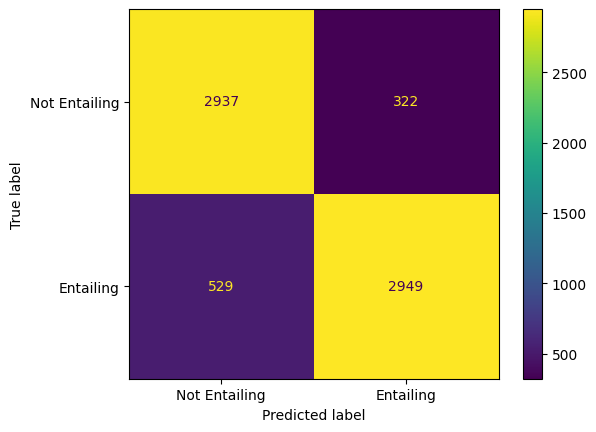

In [41]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predicted_logits))

In [43]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predicted_logits), premises=premises_og, hypotheses=hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,okay well what are we doing about recycling in...,Our community does not recycle.,6.037091,0,1
1,The port is virtually round the corner from th...,It takes at least two days to go from the port...,5.900270,1,0
2,and i don't know about your part of the countr...,I've never been to your part of the country.,5.868139,0,1
3,These pictures--including one depicting a part...,Many were terrified of the fear-inducing pictu...,5.787857,1,0
4,From Harajuku Station on the Japan Railways Ya...,The journey from Harujuku Station to Meiji Jin...,5.755737,1,0
5,"Nowadays, the Memorial building offers films a...",The memorial building hosted movie screenings ...,5.745902,1,0
6,that's one of the reasons i got out of the bus...,I quit the business because it wasn't profitab...,5.742011,1,0
7,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,5.643228,1,0
8,i don't know if you have a place there called ...,You probably have nothing like it.,5.589338,0,1
9,"Today, we re-emphasize the need for OHS to be ...",There is an effort to continue not establishin...,5.512063,0,1
